### 1. One client to rule them all

The Dynamic Annotation Framework consists of a number of different services, each with a specific set of tasks that it can perform through REST endpoints. This module is designed to ease programmatic interaction with all of the various endpoints. Going forward, we also will be increasingly using authentication tokens for programmatic access to most if not all of the services. In order to collect a given server, datastack name, and user token together into a coherent package that can be used on multiple endpoints, we will use a FrameworkClient that can build appropriately configured clients for each of the specific services.

The following examples cover each of the client subtypes that are associated with a single service. The ImageryClient, which is a more complex collection of tools, will be covered elsewhere.

#### Initializing a FrameworkClient
Assuming that the services are on `www.dynamicannotationframework.com` and authentication tokens are either not being used or set up with default values (see next section), one needs only to specify the datastack name.

In [1]:
from annotationframeworkclient import FrameworkClient

datastack_name = 'minnie65_phase3_v0'
client = FrameworkClient(datastack_name)

Just to confirm that this works, let's see if we can get the EM image source from the InfoService. If you get a reasonable looking path, everything is okay.

In [2]:
print(f"The image source is: {client.info.image_source()}")

The image source is: graphene://https://minnie.microns-daf.com/proxy/minniev2_em/


### 2. Authentication Service

Going forward, we're going to need authentication tokens for programmatic access to our services. The AuthClient handles storing and loading your token or tokens and inserting it into requests in other clients.

We can access the auth client from `client.auth`. Once you have saved a token, you probably won't interact with this client very often, however it has some convenient features for saving new tokens the first time. Let's see if you have a token already. Probably not.

In [3]:
auth = client.auth
print(f"My current token is: {auth.token}")

My current token is: b49eb82d2e53bd11edd435d5b6d9ca82


#### Getting a new token
It is not yet possible to get a new token programmatically, but the function `get_new_token()` provides instructions for how to get and save it.

By default, the token is saved to `~/.cloudvolume/secrets/chunkedgraph-secret.json` as a string under the key `token`. The following steps will save a token there.

*Note: I am not sure where the auth server is being hosted right now, so we are going to use a fake token for documentation purposes*

In [13]:
auth.get_new_token(open=True)

New Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://globalv1.daf-apis.com/auth/api/v1/refresh_token
                2) Log in with your Google credentials and copy the token shown afterward.
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                Warning! Creating a new token will invalidate the previous token!


In [ ]:
new_token = 'fake_token_123'
auth.save_token(token=new_token, overwrite=True)
print(f"My token is now: {auth.token}")

#### Loading saved tokens
Try opening `~/.cloudvolume/secrets/chunkedgraph-secret.json` to see what we just created.

If we had wanted to use a different file or a different json key, we could have specified that in auth.save_token.

Because we used the default values, this token is used automatically when we intialize a new FrameworkClient. If we wanted to use a different token file, token key, or even directly specify a token we could do so here.

In [5]:
client = FrameworkClient(datastack_name)
print(f"Now my basic token is: {client.auth.token}")

# client_direct = FrameworkClient(datastack_name, auth_token='another_fake_token_678')
# print(f"A directly specified token is: {client_direct.auth.token}")

Now my basic token is: ad0b4a3632bfc807c603b69d241b685d


If you use a FrameworkClient, the AuthClient and its token will be automatically applied to any other services without further use. 

### 3. Info Service
A datastack has a number of complex paths to various data sources that together comprise a datastack. Rather than hardcode these paths, the InfoService allows one to query the location of each data source. This is also convenient in case data sources change.

An InfoClient is accessed at `client.info`.

In [6]:
client.info

In [7]:
client = FrameworkClient(datastack_name)
print(f"This is an info client for {client.info.datastack_name} on {client.info.server_address}")

This is an info client for minnie65_phase3_v0 on https://globalv1.daf-apis.com


#### Accessing datastack information
All of the information accessible for the datastack can be seen as a dict using `get_datastack_info()`.

In [8]:
client.info.get_datastack_info()

{'local_server': 'https://minnie.microns-daf.com',
 'segmentation_source': 'graphene://https://minniev1.microns-daf.com/segmentation/table/minnie3_v0',
 'viewer_site': 'https://akhilesh-graphene-sharded-dot-neuromancer-seung-import.appspot.com/',
 'synapse_table': None,
 'analysis_database': None,
 'soma_table': None,
 'description': 'This is the initial dynamic segmentation of minnie65 phase 3, for which no proofreading is available. ',
 'aligned_volume': {'image_source': 'graphene://https://minnie.microns-daf.com/proxy/minniev2_em/',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'name': 'minnie65_phase3',
  'id': 1}}

Individual entries can be found as well. Use tab autocomplete to see the various possibilities.

In [9]:
client.info.local_server()

'https://minnie.microns-daf.com'

#### Adjusting formatting
Because of the way neuroglancer looks up data versus cloudvolume, sometimes one needs to convert between `gs://` style paths to `https://storage.googleapis.com/` stype paths. All of the path sources in the info client accept a `format_for` argument that can handle this, and correctly adapts to graphene vs precomputed data sources.

In [10]:
neuroglancer_style_source = client.info.image_source(format_for='neuroglancer')
print(f"With gs-style: { neuroglancer_style_source }")

cloudvolume_style_source = client.info.image_source(format_for='cloudvolume')
print(f"With https-style: { cloudvolume_style_source }")

With gs-style: graphene://https://minnie.microns-daf.com/proxy/minniev2_em/
With https-style: graphene://https://minnie.microns-daf.com/proxy/minniev2_em/


### 4. JSON Service

We store the JSON description of a Neuroglancer state in a simple database at the JSON Service. This is a convenient way to build states to distribute to people, or pull states to parse work by individuals. The JSON Client is at `client.state`

In [11]:
client.state

#### Retrieving a state

JSON states are found simply by their ID, which you get when uploading a state. You can download a state with `get_state_json`.

In [12]:
example_id = 5762925562167296
example_state = client.state.get_state_json(example_id)
example_state['layers'][0]

{'source': 'precomputed://https://storage.googleapis.com/neuroglancer/basil_v0/son_of_alignment/v3.04_cracks_only_normalized_rechunked',
 'type': 'image',
 'blend': 'default',
 'shaderControls': {},
 'name': 'img'}

#### Uploading a state
You can also upload states with `upload_state_json`. If you do this, the state id is returned by the function. Note that there is no easy way to query what you uploaded later, so be VERY CAREFUL with this state id if you wish to see it again.

*Note: If you are working with a Neuroglancer Viewer object or similar, in order to upload, use viewer.state.to_json() to generate this representation.*

In [13]:
example_state['layers'][0]['name'] = 'example_name'
new_id = client.state.upload_state_json(example_state)

In [14]:
test_state = client.state.get_state_json(new_id)
test_state['layers'][0]['name']

'example_name'

#### Generating Neuroglancer URLs

Neuroglancer can automatically look up a JSON state based on its ID if you pass the URL to it correctly. The function `build_neuroglancer_url` helps format these correctly. Note that you need to specify the base URL for the Neuroglancer deployment you wish to use.

In [15]:
url = client.state.build_neuroglancer_url(state_id=new_id, ngl_url='https://neuromancer-seung-import.appspot.com')
print(url)

https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.daf-apis.com/nglstate/api/v1/5723684551524352


### 5. ChunkedGraph

The ChunkedGraph client allows one to interact with the ChunkedGraph, which stores and updates the supervoxel agglomeration graph. This is most often useful for looking up an object root id of a supervoxel or looking up supervoxels belonging to a root id. The ChunkedGraph client is at `client.chunkedgraph`.

#### Look up a supervoxel
Usually in Neuroglancer, one never notices supervoxel ids, but they are important for programmatic work. In order to look up the root id for a location in space, one needs to use the supervoxel segmentation to get the associated supervoxel id. The ChunkedGraph client makes this easy using the `get_root_ids` method.

In [1]:
from annotationframeworkclient import FrameworkClient

datastack_name = 'minnie65_phase3_v0'
client = FrameworkClient(datastack_name)

In [2]:
sv_id = 109362238070465629
client.chunkedgraph.get_root_id(supervoxel_id=sv_id)

864691134988869442

However, as proofreading occurs, the root id that a supervoxel belongs to can change. By default, this function returns the current state, however one can also provide a UTC timestamp to get the root id at a particular moment in history. This can be useful for reproducible analysis. Note below that the root id for the same supervoxel is different than it is now.

In [3]:
import datetime

date_3_days_ago = datetime.datetime.now() - datetime.timedelta(days=3)

# I looked up the UTC POSIX timestamp from a day in early 2019. 
#timestamp = datetime.datetime.utcfromtimestamp(1546595253)

client.chunkedgraph.get_root_id(supervoxel_id=sv_id, timestamp=date_3_days_ago)

864691134988869442

#### Getting supervoxels for a root id

A root id is associated with a particular agglomeration of supervoxels, which can be found with the `get_leaves` method. A new root id is generated for every new change in the chunkedgraph, so time stamps do not apply.

In [4]:
root_id = 864691134988869442
client.chunkedgraph.get_leaves(root_id)

array([109291800606721042, 109291800606721603, 109291800606722557, ...,
       109502494455036181, 109502494455036957, 109502494455035267])

### 7. AnnotationEngine

The AnnotationClient is used to interact with the AnnotationEngine service to create tables from existing schema, upload new data, and download existing annotations. Note that annotations in the AnnotationEngine are not linked to any particular segmentation, and thus do not include any root ids. An annotation client is accessed with `client.annotation`.

#### Get existing tables

A list of the existing tables for the datastack can be found at with `get_tables`.

In [4]:
from annotationframeworkclient import FrameworkClient

datastack_name = 'minnie65_phase3_v0'
client = FrameworkClient(datastack_name)

In [5]:
all_tables = client.annotation.get_tables()
all_tables

['test_synapse', 'test_nuc_detection']

In [6]:
client.annotation.aligned_volume_name


'minnie65_phase3'

In [7]:
client.annotation.get_table_metadata('test_nuc_detection')

{'valid': True,
 'schema_type': 'nucleus_detection',
 'deleted': None,
 'description': 'a test table of nuclei from shangs detection,                               pt is the centroid. id corresponds to the flat_segmentation_source segmentID',
 'flat_segmentation_source': 'precomputed://https://s3-hpcrc.rc.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg',
 'table_id': 'annov1__minnie65_phase3__test_nuc_detection',
 'created': '2020-07-03T00:19:45.506256',
 'id': 4,
 'user_id': '121',
 'reference_table': None}

In [8]:
import pandas as pd
import numpy as np

In [9]:
nuc_df = pd.read_csv('/Users/forrestc/ConnectomeStack/analysis_temp/p3minnie_nucleus_seg_info.df.csv.df',
                    dtype=np.int32)
nuc_df=nuc_df.rename({'cleft_segid':'id'}, axis=1)

In [10]:
nuc_df=nuc_df.iloc[2000:3000]

In [11]:
nuc_df

,id,size,centroid_x,centroid_y,centroid_z,bbox_bx,bbox_by,bbox_bz,bbox_ex,bbox_ey,bbox_ez
2000,374507,434217,14315,14204,24092,14258,14168,24012,14387,14240,24159
2001,250564,154801,11158,5463,18566,11081,5441,18502,11239,5487,18619
2002,694831,62032,23970,8925,19172,23931,8901,19157,24021,8956,19191
2003,674748,910173,23151,15004,19806,23100,14944,19718,23223,15066,19945
2004,510119,639917,19372,4834,21257,19291,4786,21117,19444,4861,21420
...,...,...,...,...,...,...,...,...,...,...,...
2995,566770,1758266,20038,15107,25827,19969,15047,25698,20105,15160,25947
2996,364681,1430720,13932,10934,15839,13855,10885,15720,14014,10990,15949
2997,328254,2072830,13233,8918,20870,13166,8838,20760,13300,8986,20978
2998,636008,2152149,22971,5902,21645,22889,5812,21569,23069,5994,21753


In [12]:
nuc_df['pt']=nuc_df.apply(lambda x: np.array([x.centroid_x*(2**4), x.centroid_y*(2**4), x.centroid_z], dtype=np.int32), axis=1)

In [13]:
nuc_df['volume']=nuc_df['size']*((64*64*40)/(1000*1000*1000))

<IPython.core.display.Javascript object>


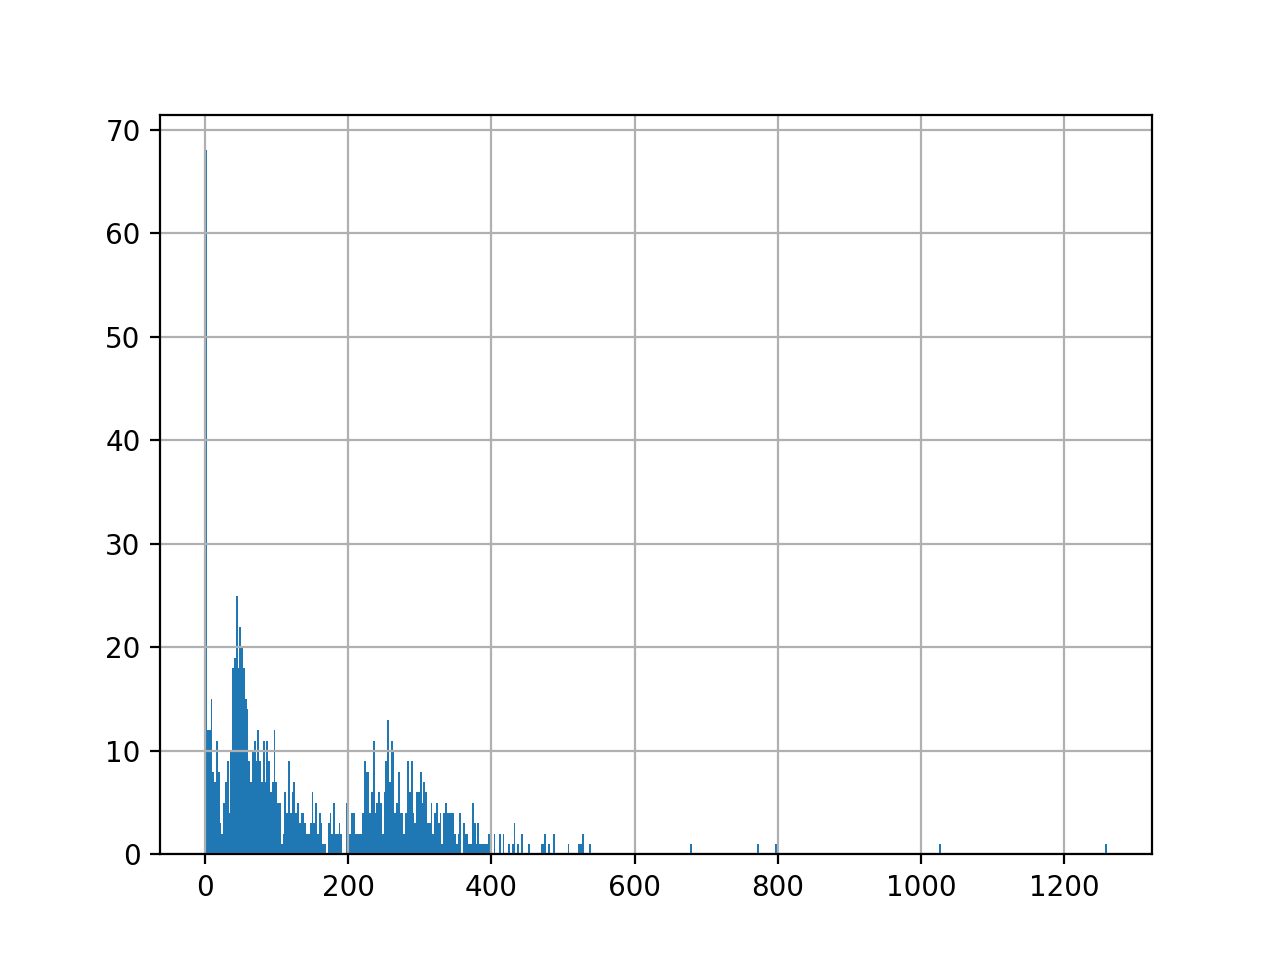

In [14]:
%matplotlib notebook
nuc_df['volume'].hist(bins=500)

In [15]:
nuc_ann_df=nuc_df[['id', 'pt', 'volume']]

In [16]:
annotations=nuc_ann_df.to_dict('records')

In [17]:
annotations

[{'id': 374507,
  'pt': array([229040, 227264,  24092], dtype=int32),
  'volume': 71.14211328},
 {'id': 250564,
  'pt': array([178528,  87408,  18566], dtype=int32),
  'volume': 25.36259584},
 {'id': 694831,
  'pt': array([383520, 142800,  19172], dtype=int32),
  'volume': 10.16332288},
 {'id': 674748,
  'pt': array([370416, 240064,  19806], dtype=int32),
  'volume': 149.12274432},
 {'id': 510119,
  'pt': array([309952,  77344,  21257], dtype=int32),
  'volume': 104.84400128},
 {'id': 278649,
  'pt': array([172736, 275472,  18606], dtype=int32),
  'volume': 153.99141376},
 {'id': 702498,
  'pt': array([382640, 175328,  19689], dtype=int32),
  'volume': 121.70641408},
 {'id': 379596,
  'pt': array([223808, 273888,  26904], dtype=int32),
  'volume': 87.75221248},
 {'id': 694433,
  'pt': array([378784, 143200,  19191], dtype=int32),
  'volume': 253.3441536},
 {'id': 377346,
  'pt': array([220528, 273808,  16063], dtype=int32),
  'volume': 10.58045952},
 {'id': 620992,
  'pt': array([34705

In [18]:
for a in annotations:
    a['pt']={'position':a['pt']}

In [19]:
annotations

[{'id': 374507,
  'pt': {'position': array([229040, 227264,  24092], dtype=int32)},
  'volume': 71.14211328},
 {'id': 250564,
  'pt': {'position': array([178528,  87408,  18566], dtype=int32)},
  'volume': 25.36259584},
 {'id': 694831,
  'pt': {'position': array([383520, 142800,  19172], dtype=int32)},
  'volume': 10.16332288},
 {'id': 674748,
  'pt': {'position': array([370416, 240064,  19806], dtype=int32)},
  'volume': 149.12274432},
 {'id': 510119,
  'pt': {'position': array([309952,  77344,  21257], dtype=int32)},
  'volume': 104.84400128},
 {'id': 278649,
  'pt': {'position': array([172736, 275472,  18606], dtype=int32)},
  'volume': 153.99141376},
 {'id': 702498,
  'pt': {'position': array([382640, 175328,  19689], dtype=int32)},
  'volume': 121.70641408},
 {'id': 379596,
  'pt': {'position': array([223808, 273888,  26904], dtype=int32)},
  'volume': 87.75221248},
 {'id': 694433,
  'pt': {'position': array([378784, 143200,  19191], dtype=int32)},
  'volume': 253.3441536},
 {'id'

In [12]:
nuc_source = 'precomputed://https://s3-hpcrc.rc.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'
client.annotation.create_table('test_nuc_detection', 'nucleus_detection',
                              'a test table of nuclei from shangs detection, \
                              pt is the centroid. id corresponds to the flat_segmentation_source segmentID',
                              flat_segmentation_source=nuc_source)



'annov1__minnie65_phase3__test_nuc_detection'

In [20]:
client.annotation.post_annotation('test_nuc_detection', annotations)

'Inserted 1000 annotations'

In [6]:
nuc_df.iloc[0].id

NameError: name 'nuc_df' is not defined

In [21]:
client.annotation.get_annotation('test_nuc_detection', annotation_ids=nuc_df.iloc[0:2].id)

[{'volume': 71.14211328,
  'valid': True,
  'pt_supervoxel_id': None,
  'pt_root_id': None,
  'pt_position': 'POINTZ(229040.0 227264.0 24092.0)',
  'id': 374507,
  'deleted': 'None',
  'created': '2020-07-08 21:34:17.600106',
  'superceded_id': None},
 {'volume': 25.36259584,
  'valid': True,
  'pt_supervoxel_id': None,
  'pt_root_id': None,
  'pt_position': 'POINTZ(178528.0 87408.0 18566.0)',
  'id': 250564,
  'deleted': 'None',
  'created': '2020-07-08 21:34:17.601125',
  'superceded_id': None}]

In [22]:
client.annotation.get_annotation_count('test_nuc_detection')

3000

In [23]:
client.annotation.delete_annotation('test_nuc_detection', nuc_df.iloc[0:2].id.values)

'2 annotations marked for deletion'

In [27]:
client.annotation.update_annotation('test_nuc_detection', {'volume': 99,
  'valid': True,
  'pt_supervoxel_id': None,
  'pt_root_id': None,
  'pt':{'position': [361792,77088,27399]},
  'id': 632503,
  'deleted': 'None',
  'created': '2020-07-03 00:26:06.101055',
  'superceded_id': None})

"['id 632503 updated']"

In [15]:
coord_ids = np.load('/Users/forrestc/ConnectomeStack/analysis_temp/coord_ids.npy')

In [11]:
sv_ids = np.load('/Users/forrestc/ConnectomeStack/analysis_temp/sv_ids.npy')

In [15]:
CHUNK_ID = SEGMENT_ID = NODE_ID = OPERATION_ID = np.dtype('uint64').newbyteorder('L')

empty_2d = np.empty((0, 2), dtype=NODE_ID)

In [17]:
np.concatenate([empty_2d])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

Each table has three main properties that can be useful to know:
* `table_name` : The table name, used to refer to it when uploading or downloading annotations. This is also passed through to the table in the Materialized database.
* `schema_name` : The name of the table's schema from EMAnnotationSchemas (see below).
* `max_annotation_id` : An upper limit on the number of annotations already contained in the table.

#### Downloading annotations

You can download the JSON representation of a data point through the `get_annotation` method. This can be useful if you need to look up information on unmaterialized data, or to see what a properly templated annotation looks like.

In [ ]:
table_name = all_tables[0]['table_name'] # 'ais_analysis_soma'
annotation_id = 100
client.annotation.get_annotation(annotation_id=annotation_id, table_name=table_name)

#### Create a new table

One can create a new table with a specified schema with the `create_table` method:

```
client.annotation.create_table(table_name='test_table',
                               schema_name='microns_func_coreg')
```

Now, new data can be generated as a dict or list of dicts following the schema and uploaded with `post_annotation`.
For example, a `microns_func_coreg` point needs to have:
    * `type` set to `microns_func_coreg`
    * `pt` set to a dict with `position` as a key and the xyz location as a value.
    * `func_id` set to an integer.
    
The following will create a new annotation and upload it to the service: 
```
new_data = {'type': 'microns_func_coreg',
            'pt': {'position': [1,2,3]},
            'func_id': 0}
            
client.annotation.post_annotation(table_name='test_table', data=[new_data])
```

### 7. EMAnnotationSchemas

The EMAnnotationSchemas client lets one look up the available schemas and how they are defined. This is mostly used for programmatic interactions between services, but can be useful when looking up schema definitions for new tables.

#### Get the list of schema 
One can get the list of all available schema with the `schema` method. Currently, new schema have to be generated on the server side, although we aim to have a generic set available to use.

In [ ]:
client.schema.schema()

#### View a specific schema

The details of each schema can be viewed with the `schema_definition` method, formatted as per JSONSchema. 

In [ ]:
example_schema = client.schema.schema_definition('microns_func_coreg')
example_schema

This is mostly useful for programmatic interaction between services at the moment, but can also be used to inspect the expected form of an annotation by digging into the format.

In [ ]:
example_schema['definitions']['FunctionalCoregistration']